# CONTENT

### 1) Set-up (importing libraries and specifying data folder)

### 2) Preprocess: Spatially intersecting administrative districts and sectors

### 3) Intersections: each social asset with each hazard as separate column

### 1) Set-up (importing libraries and specifying data folder)

In [1]:
import os
import sys
import geopandas
import pandas

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
data_folder = "/Users/lena/OneDrive - OnTheHub - The University of Oxford/University/Oxford/OX_2018_2019/stlucia/analysis/python/projects/nismod-int-hack/data/Hackathon/rv"

In [3]:
#Loading in merged social infrastructures as csv and admin

#INPUT FILE
administrative_path = os.path.join(
    data_folder, 'data','admin', 'stluc_administrative.shp')

administrative = geopandas.read_file(administrative_path)

#OUTPUT FILE

intersections_social_path = os.path.join(
    data_folder, 'results', 'intersections_social_merged.csv')

social_merged_path= os.path.join(
    data_folder, 'data', 'buildings', 'social_merged_admin.csv')

social_haz_by_sector_path = os.path.join(
    data_folder, 'results', 'social_hazards_capacity_count_sector.csv')

social_haz_count_path= os.path.join(
    data_folder, 'results', 'social_hazards_capacity_exp.csv')

social_haz_percent_exp_path= os.path.join(
    data_folder, 'results', 'social_hazards_sector%_exp.csv')

OSM_polygons_all_path = os.path.join(
        data_folder, 'data','buildings','socials.shp')

social_merged = geopandas.read_file(OSM_polygons_all_path)

# import hazards and sector ids
hazard_ids = ['1m_sea-level','4m_storm-surge','flashflooding','landslide_susceptibility']
sector_ids = ['food', 'education', 'healthcare','civic','finance','tourism', 'emergency', 
              'manufacturing', 'retail', 'wholesale', 'beverages', 'fuel']

In [4]:
sector_exp = pandas.read_csv(social_haz_percent_exp_path)
merged_intersections = pandas.read_csv(social_haz_count_path)
social_merged = pandas.read_csv(social_merged_path)
all_intersections = pandas.read_csv(intersections_social_path)

In [6]:
len(social_merged)

744

In [7]:
def load_hazard(data_folder, hazard_id):  
    hazard_path = os.path.join(
        data_folder, 'data', 'hazards', '{}.shp'.format(hazard_id))
    hazards = geopandas.read_file(hazard_path)
    hazards = hazards.to_crs({'init':'epsg:2006'})
    return hazards

In [8]:
def load_sector(data_folder, sector_id):  
    sector_path = os.path.join(
        data_folder, 'data', 'buildings', '{}.shp'.format(sector_id))
    sectors = geopandas.read_file(sector_path)
    #only use valid geometries 
    sectors = sectors.loc[sectors.is_valid]
    sectors.crs = {'init' :'epsg:2006'}

    return sectors

In [9]:
#  Adding multihazard computation
def two_multi_hazards(row):
    if row['4m_storm-surge'] > 0:
        val = row['4m_storm-surge']
    elif row['flashflooding'] > 0:
        val = row['flashflooding']
    else:
        val = 0 
    return val

def three_multi_hazards(row):
    if row['4m_storm-surge'] > 0:
        val = row['4m_storm-surge']
    elif row['flashflooding'] > 0:
        val = row['flashflooding']
    elif row['landslide_susceptibility'] > 0:
        val = row['landslide_susceptibility']
    else:
        val = 0 
    return val

In [10]:
def intersect_sector_with_admin(sectors, administrative, sector_id):
    """Intersect sectors with administrative
    """    
    intersections = geopandas.sjoin(sectors, administrative, how="inner", op='intersects')

    intersections['sector'] = sector_id
    intersections = intersections[[
        'sector',
        'id_left',
        'admin_name',
        'geometry'
    ]]

    intersections = intersections.rename(columns={
        'id_left': 'sector_id'
    })

    return intersections

## 2) Preprocess: Spatially intersecting administrative districts and sectors

In [91]:
social_merged = []
for sector_id in sector_ids:
    #load sector
    sector_df = load_sector(data_folder, sector_id)

    print(sector_id)
    sector_intersection = intersect_sector_with_admin(sector_df, administrative, sector_id)
    social_merged.append(sector_intersection)

social_merged = pandas.concat(social_merged, axis=0)
social_merged = social_merged.fillna(0)
social_merged.to_csv(social_merged_path, index=False)
social_merged['count'] = 1
social_merged = pandas.read_csv(social_merged_path)

food
education
healthcare
civic
finance
tourism
emergency
manufacturing
retail
wholesale
beverages
fuel


In [92]:
social_merged

,sector,sector_id,admin_name,geometry
0,food,85,Micoud,"POLYGON ((517900.6587941614 1530977.809440554,..."
1,food,113,Micoud,"POLYGON ((517920.0118651328 1530921.346554585,..."
2,food,115,Micoud,"POLYGON ((518737.1795286778 1530466.402227817,..."
3,food,124,Micoud,"POLYGON ((518502.4918375725 1530655.242694309,..."
4,food,149,Micoud,"POLYGON ((516138.3819419272 1527371.124477859,..."
5,food,150,Micoud,"POLYGON ((515673.6568200886 1527630.310883453,..."
6,food,207,Micoud,"POLYGON ((518455.4102847305 1531676.321625158,..."
7,food,210,Micoud,"POLYGON ((518415.2443290546 1531659.3039712, 5..."
8,food,213,Micoud,"POLYGON ((518786.5937290324 1528032.8945434, 5..."
9,food,220,Micoud,"POLYGON ((518503.0899942257 1530619.011991381,..."


## 3) Intersections: each social asset with each hazard as separate column


In [93]:
def intersect_hazard_with_sector(hazards, sectors, hazard_id, sector_id):
    """Intersect sectors with hazards
    """
    ### INTERSECTIONS WITH HAZARDS        
    intersections_sector_haz = geopandas.sjoin(sectors, hazards, how="inner", op='intersects')
    intersections_sector_haz[hazard_id] = 1
    intersections_sector_haz['sector'] = sector_id
    intersections_sector_haz = intersections_sector_haz[[
        'sector',
        'id_left', 
        hazard_id
        ]]
    intersections_sector_haz = intersections_sector_haz.rename(columns={
        'id_left': 'sector_id' 
    })
    intersections_sector_haz = intersections_sector_haz.drop_duplicates(subset='sector_id', keep='first')
    intersections_sector_haz = intersections_sector_haz.fillna(0)
    return intersections_sector_haz

In [94]:
all_intersections = []
for sector_id in sector_ids:
    sector_df = load_sector(data_folder, sector_id)
    print(sector_id)
    for hazard_id in hazard_ids:
        hazard_df = load_hazard(data_folder, hazard_id)
        print(hazard_id)
        sector_intersection = intersect_hazard_with_sector(hazard_df, sector_df, hazard_id, sector_id)
        all_intersections.append(sector_intersection)
        
all_intersections = pandas.concat(all_intersections, axis=0, sort=False)
all_intersections = all_intersections.fillna(0)
all_intersections.to_csv(intersections_social_path)
all_intersections

food
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
education
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
healthcare
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
civic
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
finance
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
tourism
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
emergency
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
manufacturing
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
retail
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
wholesale
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
beverages
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility
fuel
1m_sea-level
4m_storm-surge
flashflooding
landslide_susceptibility


,sector,sector_id,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility
7,food,92,1.0,0.0,0.0,0.0
40,food,125,1.0,0.0,0.0,0.0
187,food,432,1.0,0.0,0.0,0.0
16,food,101,1.0,0.0,0.0,0.0
26,food,111,1.0,0.0,0.0,0.0
44,food,129,1.0,0.0,0.0,0.0
85,food,170,1.0,0.0,0.0,0.0
179,food,424,1.0,0.0,0.0,0.0
57,food,142,1.0,0.0,0.0,0.0
1,food,86,0.0,1.0,0.0,0.0


In [2]:
merged_intersections = pandas.merge(
    social_merged, all_intersections, how = 'outer', on=['sector','sector_id']) 
merged_intersections = merged_intersections.fillna(0)
merged_intersections = merged_intersections.drop(columns=['Unnamed: 0'])
merged_intersections.to_csv(social_haz_count_path)


NameError: name 'social_merged' is not defined

### Add multiple hazard calculation

In [11]:
merged_intersections = pandas.read_csv(social_haz_count_path)
merged_intersections =  merged_intersections.drop(columns='Unnamed: 0')

In [12]:
hazard_ids =['1m_sea-level', '4m_storm-surge', 'flashflooding', 'landslide_susceptibility']
#ensure all values are numeric
merged_intersections[hazard_ids] = merged_intersections[hazard_ids].apply(pandas.to_numeric)

In [13]:
merged_intersections

,sector,sector_id,admin_name,geometry,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility
0,food,85,Micoud,"POLYGON ((517900.6587941614 1530977.809440554,...",0.0,0.0,0.0,0.0
1,food,113,Micoud,"POLYGON ((517920.0118651328 1530921.346554585,...",0.0,0.0,0.0,0.0
2,food,115,Micoud,"POLYGON ((518737.1795286778 1530466.402227817,...",0.0,0.0,0.0,0.0
3,food,124,Micoud,"POLYGON ((518502.4918375725 1530655.242694309,...",0.0,0.0,0.0,0.0
4,food,149,Micoud,"POLYGON ((516138.3819419272 1527371.124477859,...",0.0,0.0,0.0,0.0
5,food,150,Micoud,"POLYGON ((515673.6568200886 1527630.310883453,...",0.0,0.0,0.0,0.0
6,food,207,Micoud,"POLYGON ((518455.4102847305 1531676.321625158,...",0.0,0.0,0.0,0.0
7,food,210,Micoud,"POLYGON ((518415.2443290546 1531659.3039712, 5...",0.0,0.0,0.0,0.0
8,food,213,Micoud,"POLYGON ((518786.5937290324 1528032.8945434, 5...",0.0,0.0,0.0,0.0
9,food,220,Micoud,"POLYGON ((518503.0899942257 1530619.011991381,...",0.0,0.0,0.0,0.0


In [14]:
# Merge information for each asset - grouping by 
# -> If sector_id is the same, add the columns for each of the hazards
merged_intersections = merged_intersections.groupby([
    'sector', 'sector_id', 'admin_name',  'geometry'
    ])[
    hazard_ids
    ].sum()
merged_intersections

1m_sea-level  \
sector    sector_id admin_name   geometry                                                    
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)           0.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)           0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)             0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)           0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)           0.0   
...                                                                                    ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)           0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)           0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)           0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)           0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)           0.0   

                                                                              4m_storm-surge  \
sector    sector_id admin_name   geometry                                                      
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)             0.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)             0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)               0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)             0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)             0.0   
...                                                                                      ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)             0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)             0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)             0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)             0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)             0.0   

                                                                              flashflooding  \
sector    sector_id admin_name   geometry                                                     
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)            1.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)            0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)              0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)            0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)            0.0   
...                                                                                     ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)            0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)            0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)            0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)            0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)            0.0   

                                                                              landslide_susceptibility  
sector    sector_id admin_name   geometry                                                               
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)                       0.0  
          1         Vieux Fort   POINT (513926.85372414

In [15]:
#create a new hazard with combined hazard 
merged_intersections['storm_flash'] = merged_intersections.apply(two_multi_hazards, axis=1)
merged_intersections['storm_flash_landslide']= merged_intersections.apply(three_multi_hazards, axis=1)

In [16]:
merged_intersections

1m_sea-level  \
sector    sector_id admin_name   geometry                                                    
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)           0.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)           0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)             0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)           0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)           0.0   
...                                                                                    ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)           0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)           0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)           0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)           0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)           0.0   

                                                                              4m_storm-surge  \
sector    sector_id admin_name   geometry                                                      
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)             0.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)             0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)               0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)             0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)             0.0   
...                                                                                      ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)             0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)             0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)             0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)             0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)             0.0   

                                                                              flashflooding  \
sector    sector_id admin_name   geometry                                                     
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)            1.0   
          1         Vieux Fort   POINT (513926.8537241495 1518527.576944268)            0.0   
          2         Vieux Fort   POINT (511300.8445351303 1519871.2305403)              0.0   
          3         Vieux Fort   POINT (511111.7459802366 1519754.493451351)            0.0   
          4         Gros Islet   POINT (513492.7237154493 1556917.198700076)            0.0   
...                                                                                     ...   
wholesale 39        Vieux Fort   POINT (511203.8043293236 1518708.253673777)            0.0   
          41        Vieux Fort   POINT (511083.5237126345 1518788.888724072)            0.0   
          43        Vieux Fort   POINT (511111.7459802366 1519754.493451351)            0.0   
          46        Castries     POINT (509199.5298547877 1549371.553906726)            0.0   
          47        Gros Islet   POINT (513492.7237154493 1556917.198700076)            0.0   

                                                                              landslide_susceptibility  \
sector    sector_id admin_name   geometry                                                                
beverages 0         Anse-la-Raye POINT (505378.4324729986 1542361.995763945)                       0.0   
          1         Vieux Fort   POINT (513926.85372

## Count number of assets per sector

In [17]:
merged_intersections['count'] = 1

In [18]:
sector = merged_intersections.groupby(['sector']).sum().reset_index()


In [19]:
sector

,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,count
0,beverages,0.0,0.0,1.0,0.0,1.0,1.0,8
1,civic,10.0,33.0,27.0,1.0,38.0,39.0,52
2,education,1.0,17.0,31.0,7.0,37.0,43.0,176
3,emergency,2.0,5.0,7.0,0.0,8.0,8.0,16
4,finance,3.0,15.0,15.0,1.0,20.0,21.0,29
5,food,9.0,41.0,42.0,6.0,62.0,67.0,216
6,fuel,1.0,5.0,4.0,1.0,7.0,8.0,29
7,healthcare,2.0,9.0,14.0,3.0,17.0,20.0,106
8,manufacturing,0.0,1.0,4.0,0.0,5.0,5.0,35
9,retail,0.0,0.0,2.0,0.0,2.0,2.0,12


In [20]:
sector.index = sector.sector


In [21]:
sector.to_csv(social_haz_by_sector_path)
sector

,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,count
sector,,,,,,,,
beverages,beverages,0.0,0.0,1.0,0.0,1.0,1.0,8
civic,civic,10.0,33.0,27.0,1.0,38.0,39.0,52
education,education,1.0,17.0,31.0,7.0,37.0,43.0,176
emergency,emergency,2.0,5.0,7.0,0.0,8.0,8.0,16
finance,finance,3.0,15.0,15.0,1.0,20.0,21.0,29
food,food,9.0,41.0,42.0,6.0,62.0,67.0,216
fuel,fuel,1.0,5.0,4.0,1.0,7.0,8.0,29
healthcare,healthcare,2.0,9.0,14.0,3.0,17.0,20.0,106
manufacturing,manufacturing,0.0,1.0,4.0,0.0,5.0,5.0,35


### Calculate % of exposed capacity per sector

In [22]:
sector_exp = sector
hazard_ids =['1m_sea-level', '4m_storm-surge', 'flashflooding', 'landslide_susceptibility', 'storm_flash', 'storm_flash_landslide']

for hazard_id in hazard_ids:
    sector[hazard_id] = round((sector[hazard_id]/sector['count'])*100)
sector_exp = sector_exp.drop(['count'], axis=1)    


In [23]:
sector_exp = sector_exp.drop(columns='sector')
sector_exp.to_csv(social_haz_percent_exp_path)
sector_exp

,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide
sector,,,,,,
beverages,0.0,0.0,12.0,0.0,12.0,12.0
civic,19.0,63.0,52.0,2.0,73.0,75.0
education,1.0,10.0,18.0,4.0,21.0,24.0
emergency,12.0,31.0,44.0,0.0,50.0,50.0
finance,10.0,52.0,52.0,3.0,69.0,72.0
food,4.0,19.0,19.0,3.0,29.0,31.0
fuel,3.0,17.0,14.0,3.0,24.0,28.0
healthcare,2.0,8.0,13.0,3.0,16.0,19.0
manufacturing,0.0,3.0,11.0,0.0,14.0,14.0


## PLOT SOCIAL INFRASTRUCTURES

In [120]:
#sector_exp = pandas.read_csv(social_haz_percent_exp_path)

plot_social_path = os.path.join(
        data_folder, 'figures', 'fig_social_inf_stagged_hazards.svg')

In [121]:
def plot_to_ax(ax, title, hazard):
    ax = hazard.plot(ax=ax,kind='bar',use_index=True, legend = False,color=['red','green','blue','yellow','purple', 'orange'], alpha=0.4)#x=sector_exp['sector']
    
    ax.set_ylim(0,100)
    ax.set_title(title,fontweight = 'bold')
    ax.set_ylabel('Percentage of total assets exposed')
    ax.tick_params(axis='x', rotation = 90)
    ax.set_xlabel('social infrastructures')

<IPython.core.display.Javascript object>


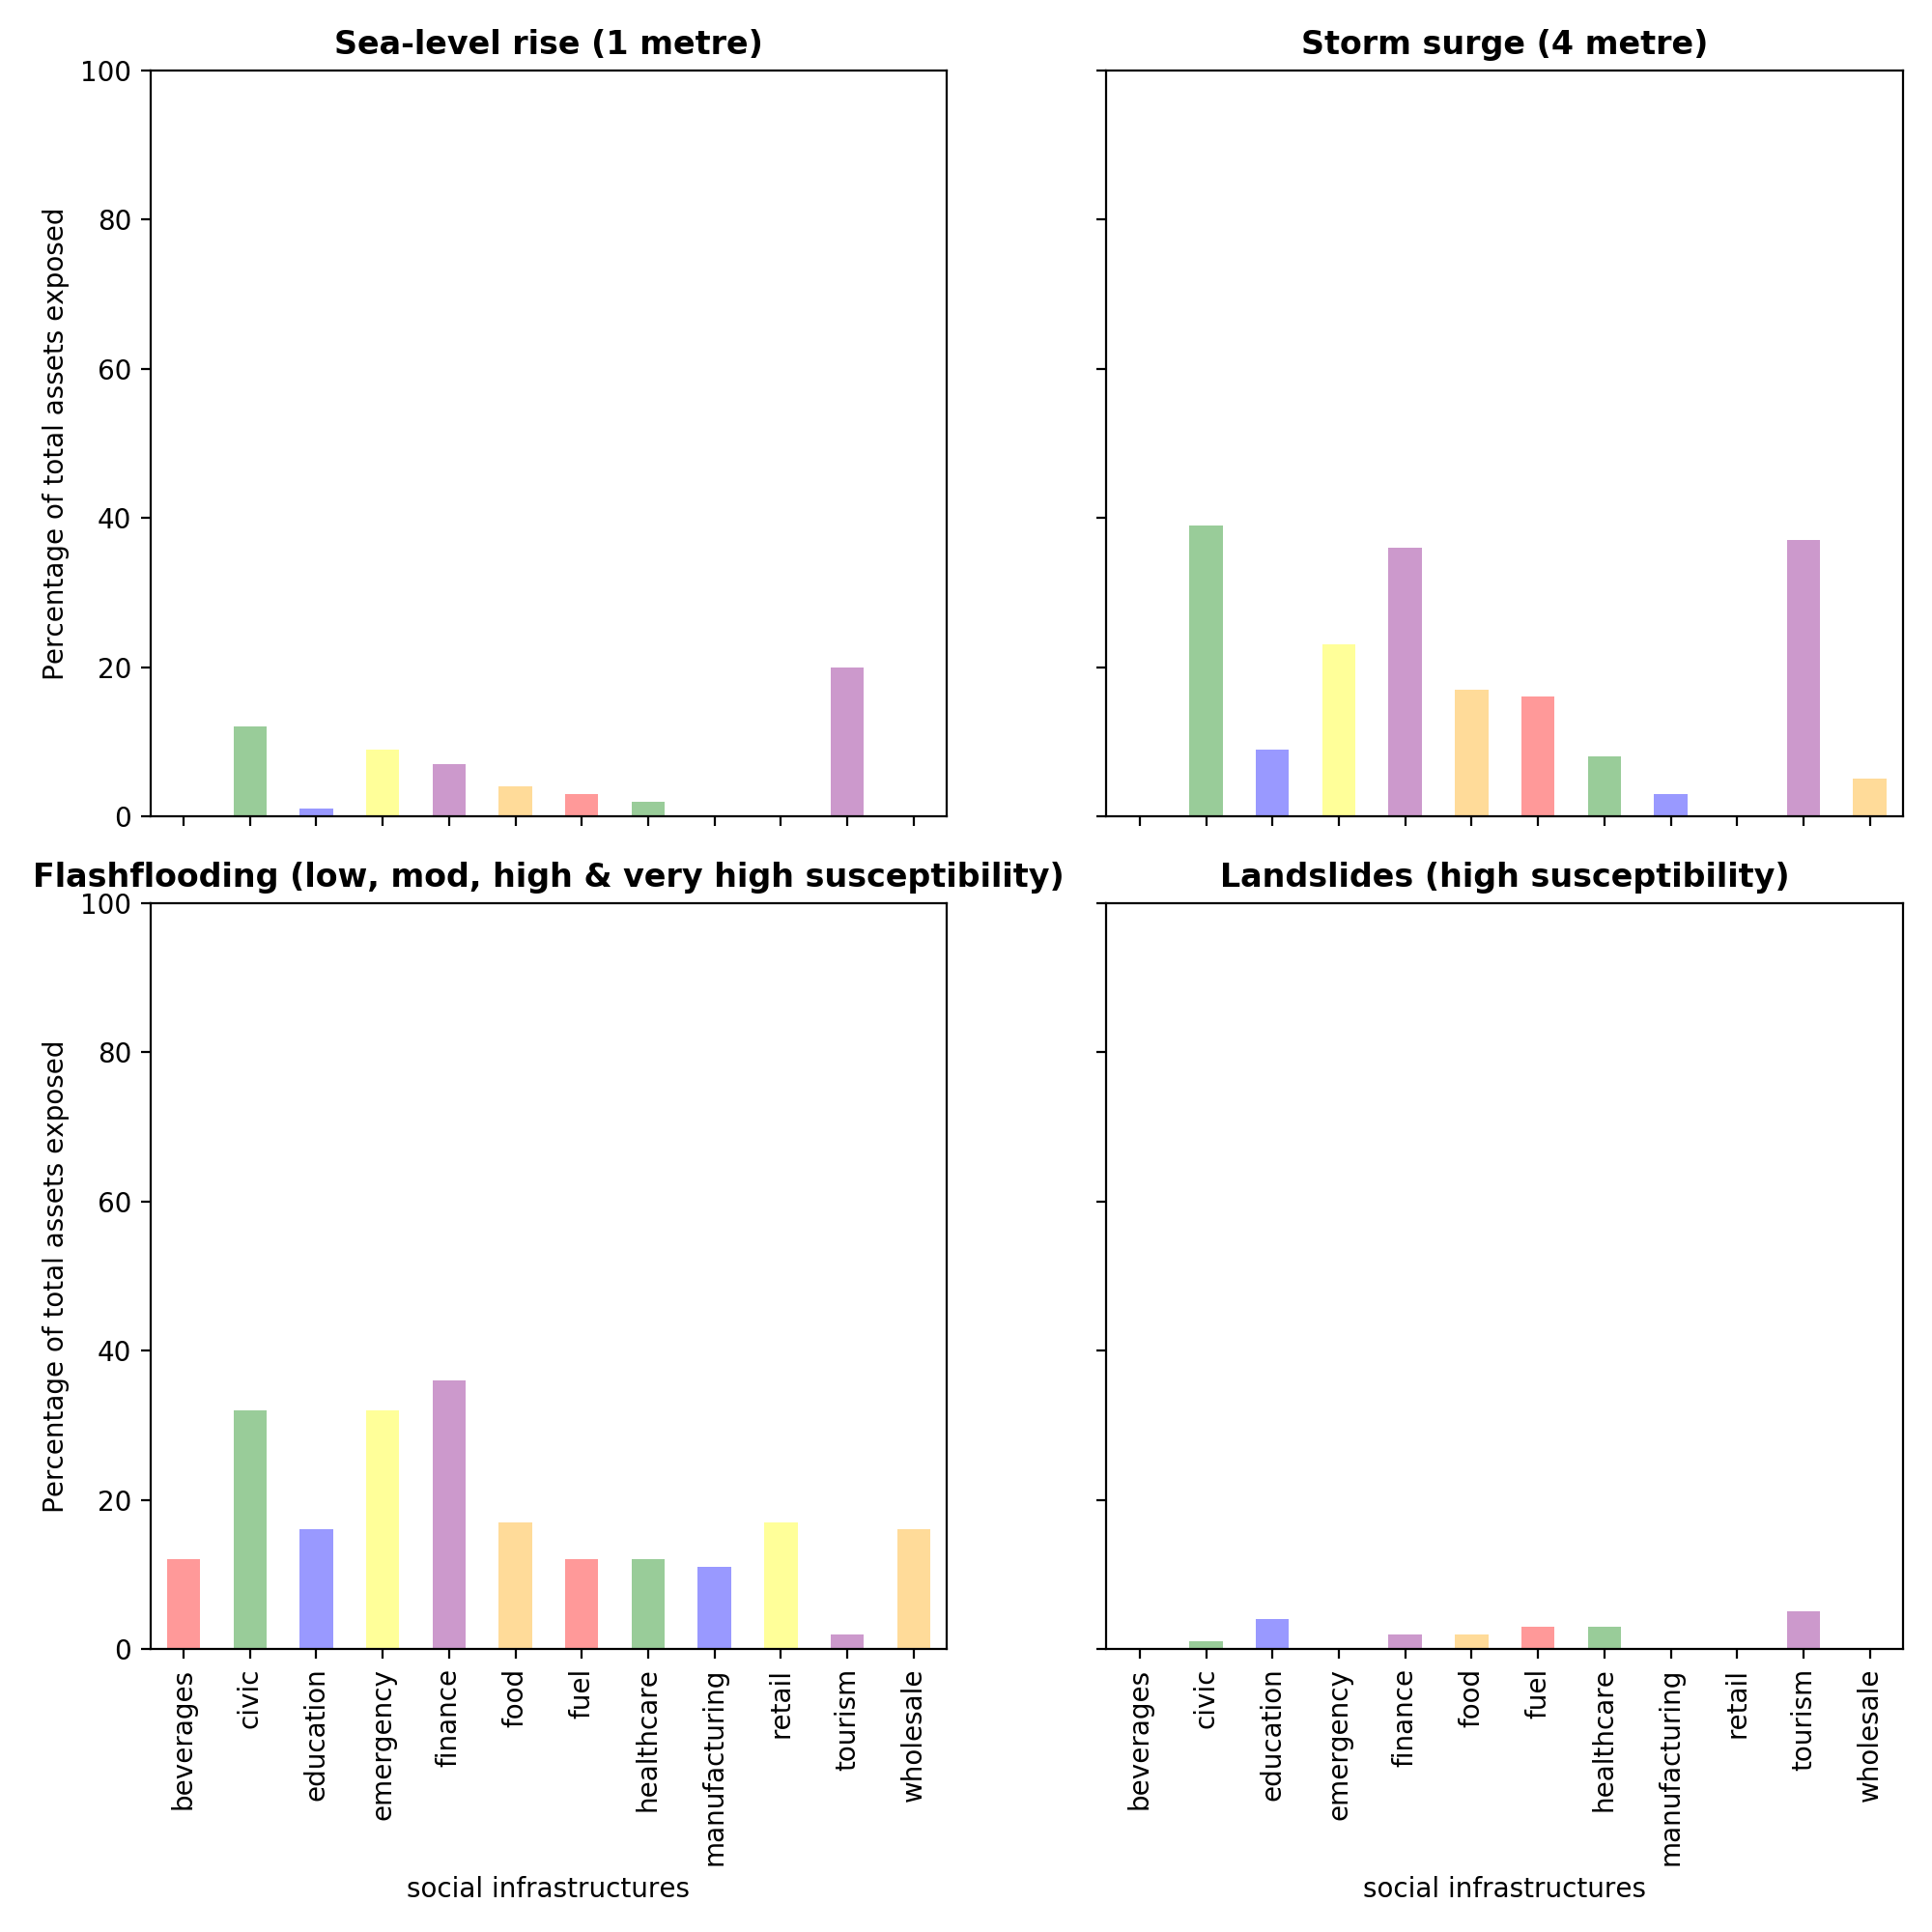

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(10,10), tight_layout = True)

plot_to_ax(axes[0,0], 'Sea-level rise (1 metre)', sector_exp['1m_sea-level'])
plot_to_ax(axes[0,1], 'Storm surge (4 metre)', sector_exp['4m_storm-surge'])
plot_to_ax(axes[1,0], 'Flashflooding (low, mod, high & very high susceptibility)', sector_exp['flashflooding'])
plot_to_ax(axes[1,1], 'Landslides (high susceptibility)', sector_exp['landslide_susceptibility'])
plt.savefig(plot_social_path)
plt.show()

# BY ADMIN CALCULATION

In [25]:
admin_social_cum_exp_path = os.path.join(
    data_folder, 'results', 'admin_social_cum_geo.csv')

admin_social_cum_exp_disag_path = os.path.join(
    data_folder, 'results', 'admin_social_cum_disag.csv')

admin_social_exp_path = os.path.join(
    data_folder, 'results','admin_social_sector_exp.csv')


In [26]:
social_admin = merged_intersections.groupby(['admin_name','sector']).sum().reset_index()
social_admin

,admin_name,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,count
0,Anse-la-Raye,beverages,0.0,0.0,1.0,0.0,1.0,1.0,1
1,Anse-la-Raye,civic,1.0,4.0,3.0,0.0,4.0,4.0,4
2,Anse-la-Raye,education,0.0,3.0,6.0,0.0,6.0,6.0,12
3,Anse-la-Raye,emergency,0.0,0.0,2.0,0.0,2.0,2.0,2
4,Anse-la-Raye,food,0.0,6.0,12.0,3.0,13.0,15.0,28
5,Anse-la-Raye,healthcare,0.0,0.0,2.0,0.0,2.0,2.0,7
6,Anse-la-Raye,manufacturing,0.0,0.0,1.0,0.0,1.0,1.0,1
7,Canaries,education,0.0,1.0,3.0,1.0,3.0,3.0,4
8,Canaries,emergency,0.0,0.0,1.0,0.0,1.0,1.0,1
9,Canaries,food,0.0,1.0,2.0,1.0,2.0,3.0,10


### Exporting overview of percentage of sector exposed with admin info

In [28]:
social_admin_stagged = social_admin.copy()
for hazard_id in hazard_ids:
    social_admin_stagged[hazard_id] = round((social_admin_stagged[hazard_id] / social_admin_stagged['count'])*100)
#social_admin_stagged = social_admin_stagged.drop(columns={'Unnamed: 0', 'sector_id', 'count'})
social_admin_stagged = social_admin_stagged.set_index('admin_name')
social_admin_stagged.to_csv(admin_social_exp_path)

In [29]:
social_admin_stagged

,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,storm_flash,storm_flash_landslide,count
admin_name,,,,,,,,
Anse-la-Raye,beverages,0.0,0.0,100.0,0.0,100.0,100.0,1
Anse-la-Raye,civic,25.0,100.0,75.0,0.0,100.0,100.0,4
Anse-la-Raye,education,0.0,25.0,50.0,0.0,50.0,50.0,12
Anse-la-Raye,emergency,0.0,0.0,100.0,0.0,100.0,100.0,2
Anse-la-Raye,food,0.0,21.0,43.0,11.0,46.0,54.0,28
Anse-la-Raye,healthcare,0.0,0.0,29.0,0.0,29.0,29.0,7
Anse-la-Raye,manufacturing,0.0,0.0,100.0,0.0,100.0,100.0,1
Canaries,education,0.0,25.0,75.0,25.0,75.0,75.0,4
Canaries,emergency,0.0,0.0,100.0,0.0,100.0,100.0,1


### Computing sector exposure for all different administrative areas


In [126]:
def merge_admin(sector_id, administrative):
    sector = social_admin[social_admin['sector'] == sector_id]
    admin_social_sector =  pandas.merge(administrative, sector, on ='admin_name', how='left')
    admin_social_sector['sector'] = sector_id
    return admin_social_sector

## Export each admin and sector

In [127]:
for sector_id in sector_ids:
    admin_social = merge_admin(sector_id, administrative)
    admin_social = geopandas.GeoDataFrame(admin_social)
    admin_social.crs = {'init': 'epsg:2006'}
    admin_social = admin_social.reset_index()
    for hazard_id in hazard_ids:
            admin_social[hazard_id] = round((admin_social[hazard_id] / admin_social['count'])*100)
    admin_social = admin_social.rename(columns={
        '1m_sea-level': 'sea-lev_1m',
        '4m_storm-surge': 'storm_s_4m',
        'flashflooding': 'flashflood', 
        'landslide_susceptibility':'landslide'
    })
    admin_social = admin_social.drop(columns=['Unnamed: 0', 'sector_id', 'index', 'id'])
    admin_social = admin_social.fillna(0)
    print(admin_social)
    admin_social_path = os.path.join(
        data_folder, 'results','admin_{}.shp'.format(sector_id))
    admin_social.to_file(admin_social_path)

     admin_name                                           geometry sector  \
0  Anse-la-Raye  POLYGON ((504489.1002518567 1543070.570047858,...   food   
1      Canaries  POLYGON ((504962.9645831303 1534981.799464189,...   food   
2      Castries  POLYGON ((504489.1002518567 1543070.570047858,...   food   
3      Choiseul  POLYGON ((507850.020189992 1529299.173142115, ...   food   
4       Dennery  POLYGON ((521289.1197935755 1543615.433000766,...   food   
5    Gros Islet  POLYGON ((514096.4336815997 1543239.529323319,...   food   
6       Laborie  POLYGON ((510296.0161504431 1518209.724388601,...   food   
7        Micoud  (POLYGON ((519386.4274498464 1533181.09109453,...   food   
8     Soufriere  POLYGON ((508887.6301650093 1530098.062839435,...   food   
9    Vieux Fort  (POLYGON ((507850.020189992 1529299.173142115,...   food   

   sea-lev_1m  storm_s_4m  flashflood  landslide  count  
0         0.0        18.0        35.0        9.0     34  
1         0.0         9.0        18.

     admin_name                                           geometry  \
0  Anse-la-Raye  POLYGON ((504489.1002518567 1543070.570047858,...   
1      Canaries  POLYGON ((504962.9645831303 1534981.799464189,...   
2      Castries  POLYGON ((504489.1002518567 1543070.570047858,...   
3      Choiseul  POLYGON ((507850.020189992 1529299.173142115, ...   
4       Dennery  POLYGON ((521289.1197935755 1543615.433000766,...   
5    Gros Islet  POLYGON ((514096.4336815997 1543239.529323319,...   
6       Laborie  POLYGON ((510296.0161504431 1518209.724388601,...   
7        Micoud  (POLYGON ((519386.4274498464 1533181.09109453,...   
8     Soufriere  POLYGON ((508887.6301650093 1530098.062839435,...   
9    Vieux Fort  (POLYGON ((507850.020189992 1529299.173142115,...   

          sector  sea-lev_1m  storm_s_4m  flashflood  landslide  count  
0  manufacturing         0.0         0.0       100.0        0.0    1.0  
1  manufacturing         0.0         0.0         0.0        0.0    0.0  
2  manufac

### [old_v072019]Combine administrative areas for each asset 

In [131]:
admin_social_sector = []
for sector_id in sector_ids:
    admin_social = merge_admin(sector_id, administrative)
    admin_social_sector.append(admin_social)
admin_social_sector = pandas.concat(admin_social_sector, axis=0)
admin_social_sector = admin_social_sector.drop(['geometry','sector_id','id', 'Unnamed: 0'], axis=1)
admin_social_sector


,admin_name,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility,count
0,Anse-la-Raye,food,0.0,6.0,12.0,3.0,34.0
1,Canaries,food,0.0,1.0,2.0,1.0,11.0
2,Castries,food,5.0,13.0,22.0,1.0,93.0
3,Choiseul,food,0.0,1.0,0.0,0.0,11.0
4,Dennery,food,0.0,1.0,1.0,0.0,5.0
5,Gros Islet,food,3.0,6.0,1.0,1.0,31.0
6,Laborie,food,0.0,4.0,0.0,0.0,7.0
7,Micoud,food,0.0,0.0,0.0,0.0,11.0
8,Soufriere,food,1.0,5.0,4.0,0.0,17.0
9,Vieux Fort,food,0.0,4.0,0.0,0.0,27.0


### Percentage of total assets of sector within an administrative district exposed to each hazard

In [132]:
for hazard_id in hazard_ids:
    admin_social_sector[hazard_id] = round((admin_social_sector[hazard_id] / admin_social_sector['count'])*100)

admin_social_sector = admin_social_sector.fillna(0)

#sector_exp.index = sector_exp.sector
admin_social_sector = admin_social_sector.drop(['count'], axis=1)

admin_social_sector

,admin_name,sector,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility
0,Anse-la-Raye,food,0.0,18.0,35.0,9.0
1,Canaries,food,0.0,9.0,18.0,9.0
2,Castries,food,5.0,14.0,24.0,1.0
3,Choiseul,food,0.0,9.0,0.0,0.0
4,Dennery,food,0.0,20.0,20.0,0.0
5,Gros Islet,food,10.0,19.0,3.0,3.0
6,Laborie,food,0.0,57.0,0.0,0.0
7,Micoud,food,0.0,0.0,0.0,0.0
8,Soufriere,food,6.0,29.0,24.0,0.0
9,Vieux Fort,food,0.0,15.0,0.0,0.0


In [133]:
admin_social_cum_exp = admin_social_sector.groupby(['admin_name']).sum().reset_index()

admin_social_cum_exp

,admin_name,1m_sea-level,4m_storm-surge,flashflooding,landslide_susceptibility
0,Anse-la-Raye,12.0,88.0,442.0,9.0
1,Canaries,0.0,26.0,168.0,126.0
2,Castries,45.0,189.0,314.0,16.0
3,Choiseul,0.0,9.0,0.0,107.0
4,Dennery,0.0,93.0,286.0,0.0
5,Gros Islet,33.0,175.0,53.0,3.0
6,Laborie,0.0,232.0,0.0,25.0
7,Micoud,0.0,0.0,0.0,0.0
8,Soufriere,120.0,248.0,179.0,56.0
9,Vieux Fort,50.0,177.0,0.0,0.0


In [134]:
admin_social_cum_exp_geo = pandas.merge(administrative, admin_social_cum_exp, on='admin_name')
admin_social_cum_exp.to_csv(admin_social_cum_exp_path, index=False)
